In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import time
import re

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('data.csv',encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#**Apa yang harus pertamakali dilakukan**

- Data set yang digunakan merupakan open data dari Kaggle. 
- Kolom Country tidak perlu dihiraukan untuk kasus ini
- Tahun di kolom InvoiceDate perlu diganti ke tahun 2020 sampai 2021 untuk kasus ini
- Data dalam kolom UnitPrice dalam US dollar
- Kamu bisa menggunakan data pendukung atau asumsi yang dapat dijustifikasi


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Convert to date time**

In [ ]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)

**Check country**

In [ ]:
#Total Country
df.Country.nunique()

38

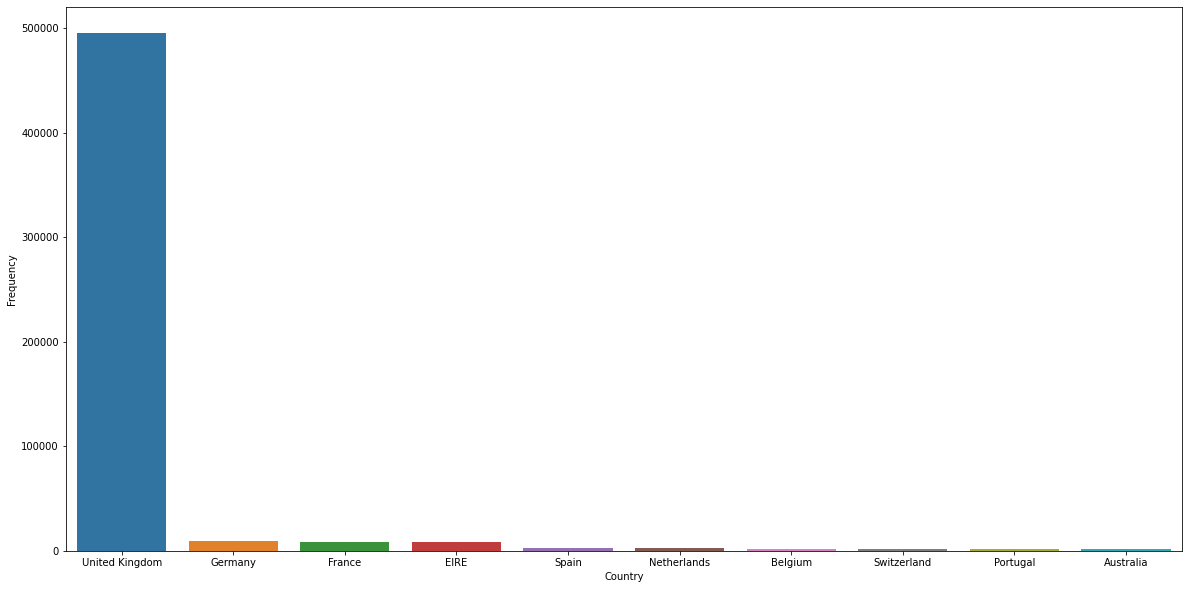

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x = 'Country',
              data = df,
              order = df.Country.value_counts().iloc[:10].index)
plt.ylabel('Frequency')
plt.show()

**Drop Country**<br>
There are a lots of countries in the dataset and UK is the dominan. So I will use UK data than drop the country.

In [ ]:
#drop country
df2 = df[df.Country == 'United Kingdom']  
df2 = df.drop('Country', axis=1)

**Change to 2020 - 2021**<br>
I don't want to lose the information. So I tried to convert data to 2020-2021 but with the same day. 

In [ ]:
print(df2.InvoiceDate.min())

2010-12-01 08:26:00


In [ ]:
#friday
print(df2.InvoiceDate.max())
df2.InvoiceDate.max().dayofweek

2011-12-09 12:50:00


4

Because 0 is Monday, so 4 is Friday

In [ ]:
# 2021, friday in Desember and it is near with 21st is 17
additional_day = (pd.to_datetime('2021-02-12 12:50:00')-df2.InvoiceDate.max()).days

In [ ]:
def convert_date(x):
  return x+datetime.timedelta(additional_day)

In [ ]:
df3 = df2.copy()
df3.InvoiceDate = df3.InvoiceDate.apply(convert_date)

In [ ]:
df2[df2.InvoiceDate == df2.InvoiceDate.max()].head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
541894,581587,22631,CIRCUS PARADE LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0


In [ ]:
df3[df3.InvoiceDate == df3.InvoiceDate.max()].head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
541894,581587,22631,CIRCUS PARADE LUNCH BOX,12,2021-02-12 12:50:00,1.95,12680.0


#**Preprocessing**

##**Handling Null Value**

In [ ]:
df3.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64

In [ ]:
df3.shape

(541909, 7)

**Drop both description and customer ID is null**<br> 
We need to filter our dataset and exclude data with this condition because we don't get any infromation from it.

In [ ]:
df3[(df3.Description.isnull()) & (df3.CustomerID.isnull())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2020-02-05 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2020-02-05 14:32:00,0.0,NaN
1971,536546,22145,NaN,1,2020-02-05 14:33:00,0.0,NaN
1972,536547,37509,NaN,1,2020-02-05 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2020-02-05 14:34:00,0.0,NaN
...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2021-02-10 18:26:00,0.0,NaN
535326,581203,23406,NaN,15,2021-02-10 18:31:00,0.0,NaN
535332,581209,21620,NaN,6,2021-02-10 18:35:00,0.0,NaN
536981,581234,72817,NaN,27,2021-02-11 10:33:00,0.0,NaN


In [ ]:
df3.shape

(541909, 7)

In [ ]:
both_null_index = df3[(df3.Description.isnull()) & (df3.CustomerID.isnull())].index
df3.drop(index=both_null_index, inplace=True)
df3.shape

(540455, 7)

In [ ]:
df3.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
dtype: int64

**Check data where customer ID is null**<br> 
We can use this data for product analysis, becase we don't need customer ID to analysis that product. But why the customer ID is NaN...?

In [ ]:
df3[(df3.Description.notnull()) & (df3.CustomerID.isnull())]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2020-02-05 14:32:00,2.51,NaN
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2020-02-05 14:32:00,2.51,NaN
1445,536544,21786,POLKADOT RAIN HAT,4,2020-02-05 14:32:00,0.85,NaN
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2020-02-05 14:32:00,1.66,NaN
1447,536544,21790,VINTAGE SNAP CARDS,9,2020-02-05 14:32:00,1.66,NaN
...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2021-02-12 10:26:00,4.13,NaN
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2021-02-12 10:26:00,4.13,NaN
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2021-02-12 10:26:00,4.96,NaN
541539,581498,85174,S/4 CACTI CANDLES,1,2021-02-12 10:26:00,10.79,NaN


**drop data with description == ?**

In [ ]:
df3[df3.Description == '?'].head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
7313,537032,21275,?,-30,2020-02-07 16:50:00,0.0,NaN


In [ ]:
both_null_index = df3[(df3.Description == '?')].index
df3.drop(index=both_null_index, inplace=True)

##**Handling Data Anomaly**

In [ ]:
df3.describe()

,Quantity,UnitPrice,CustomerID
count,540408.000000,540408.000000,406829.000000
mean,9.606525,4.623921,15287.690570
std,217.889936,96.893831,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- There are some data anomaly where the value is minus. We know that the quantity and unitprice will never be minus except the cancel the product.
- Max quantity is 80995 and min quantity is 80995, i think it's not possible where product with quantity less then 0, except discount.

###Check outlier

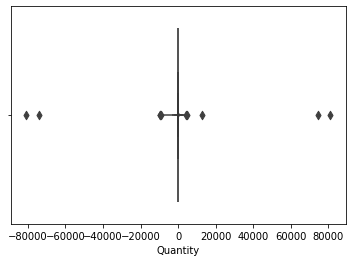

In [ ]:
sns.boxenplot(df3.Quantity);

In [ ]:
def outlier_check(data):
  q1, q3 = data.quantile(0.25), data.quantile(0.75)
  iqr = q3-q1
  return (q1-iqr*1.5), (q3+iqr*1.5)

In [ ]:
lb, ub = outlier_check(df3.Quantity)
print('Lower bound {0}, upper bound{1} ' .format(lb, ub))

Lower bound -12.5, upper bound23.5 


The Question is why the quantity and price are minus..?

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df3[(df3.Quantity<-20)|(df3.Quantity>10000)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2020-02-05 10:24:00,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2020-02-05 10:24:00,0.29,17548.0
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2020-02-05 10:24:00,0.29,17548.0
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2020-02-05 10:24:00,1.65,17548.0
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2020-02-06 14:23:00,0.03,15838.0
...,...,...,...,...,...,...,...
538919,581422,23169,smashed,-235,2021-02-11 15:24:00,0.00,NaN
540078,C581462,16219,HOUSE SHAPE PENCIL SHARPENER,-48,2021-02-11 18:51:00,0.06,12985.0
540079,C581462,21642,ASSORTED TUTTI FRUTTI PEN,-72,2021-02-11 18:51:00,0.29,12985.0
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2021-02-12 09:15:00,2.08,16446.0


Note:
- Why there is a latter in invoice no and stock code. What doest it mean? 
- What kinds of letters are there?

In [ ]:
#casefoldong
def to_lower(x):
  return x.lower()

df3.Description = df3.Description.apply(to_lower)

**Check InvoiceNo**

In [ ]:
code_tmp = []
def invoice_code(x):
  result = re.findall(r'[a-zA-z]+', x)
  result = ''.join(result)
  if result not in code_tmp and result != '':
    code_tmp.append(result)

df3.InvoiceNo.apply(invoice_code)
code_tmp

['C', 'A']

Check Invoice containing the letter A

In [ ]:
df3[df3.InvoiceNo.str.contains('A')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299982,A563185,B,adjust bad debt,1,2020-10-16 14:50:00,11062.06,NaN
299983,A563186,B,adjust bad debt,1,2020-10-16 14:51:00,-11062.06,NaN
299984,A563187,B,adjust bad debt,1,2020-10-16 14:52:00,-11062.06,NaN


In [ ]:
#I think this isn't important, so we can drop this index
df3.drop(index=df3[df3.InvoiceNo.str.contains('A')].index, inplace=True)

Check Invoice containing the letter C, make sure that all the value is minus

In [ ]:
print("The number of data: ", df3[df3.InvoiceNo.str.contains('C')].shape[0])
df3[df3.InvoiceNo.str.contains('C')].head()

The number of data:  9288


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,discount,-1,2020-02-05 09:41:00,27.50,14527.0
154,C536383,35004C,set of 3 coloured flying ducks,-1,2020-02-05 09:49:00,4.65,15311.0
235,C536391,22556,plasters in tin circus parade,-12,2020-02-05 10:24:00,1.65,17548.0
236,C536391,21984,pack of 12 pink paisley tissues,-24,2020-02-05 10:24:00,0.29,17548.0
237,C536391,21983,pack of 12 blue paisley tissues,-24,2020-02-05 10:24:00,0.29,17548.0


In [ ]:
df3[(df3.InvoiceNo.str.contains('C'))&(df3.Quantity >= 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID


My Assumption why the quantity is minus:
- Discount
- Cancel order
- Anomaly data

But we need to make sure it, how about the data that doesn't containing C in its InvoiceNo. Are all the data positive ?

In [ ]:
df3[(~df3.InvoiceNo.str.contains('C'))&(df3.Quantity <= 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
13217,537425,84968F,check,-20,2020-02-10 15:35:00,0.0,NaN
13218,537426,84968E,check,-35,2020-02-10 15:36:00,0.0,NaN
13264,537432,35833G,damages,-43,2020-02-10 16:10:00,0.0,NaN
21338,538072,22423,faulty,-13,2020-02-13 14:10:00,0.0,NaN
22296,538161,46000S,dotcom sales,-100,2020-02-13 17:25:00,0.0,NaN
...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2021-02-10 18:36:00,0.0,NaN
535335,581212,22578,lost,-1050,2021-02-10 18:38:00,0.0,NaN
535336,581213,22576,check,-30,2021-02-10 18:38:00,0.0,NaN
536908,581226,23090,missing,-338,2021-02-11 09:56:00,0.0,NaN


In [ ]:
#Check count of disription where InvoiceNo doesn't contain C and quantity < 0
desc = df3[(~df3.InvoiceNo.str.contains('C'))&(df3.Quantity <= 0)]
print("The number of quantity: ", desc.Quantity.sum()*-1)
desc.Description.value_counts().head(50)

The number of quantity:  151305


check                               123
damaged                              57
damages                              46
sold as set on dotcom                20
thrown away                           9
unsaleable, destroyed.                9
??                                    7
wet damaged                           5
damages?                              5
ebay                                  5
smashed                               4
missing                               4
dotcom sales                          3
incorrect stock entry.                3
crushed                               3
printing smudges/thrown away          3
wet pallet                            3
dotcom                                3
?missing                              2
stock check                           2
wet/rusty                             2
sold as 1                             2
???missing                            2
reverse 21/5/10 adjustment            2
water damaged                         2


All of the data is about damage product, checking, missing, etc. So just drop the data. Because we just want to analysis products that are sold.

In [ ]:
print("The number of data before checking the anomali \t\t\t\t: ", df3.shape[0])
print("The number of InvoiceNo containing letter C and without C but qty < 0 \t: ", 9288+433)
print("The number of data without C and negative qty \t\t\t\t: ", df3[(~df3.InvoiceNo.str.contains('C'))&(df3.Quantity > 0)].shape[0])

The number of data before checking the anomali 				:  540405
The number of InvoiceNo containing letter C and without C but qty < 0 	:  9721
The number of data without C and negative qty 				:  530684


In [ ]:
#drop damage data product
df3.drop(index=df3[(~df3.InvoiceNo.str.contains('C'))&(df3.Quantity <= 0)].index, inplace=True)

Handling **discount, cancel order**, etc

In [ ]:
df3[df3.InvoiceNo.str.contains('C')].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,discount,-1,2020-02-05 09:41:00,27.50,14527.0
154,C536383,35004C,set of 3 coloured flying ducks,-1,2020-02-05 09:49:00,4.65,15311.0
235,C536391,22556,plasters in tin circus parade,-12,2020-02-05 10:24:00,1.65,17548.0
236,C536391,21984,pack of 12 pink paisley tissues,-24,2020-02-05 10:24:00,0.29,17548.0
237,C536391,21983,pack of 12 blue paisley tissues,-24,2020-02-05 10:24:00,0.29,17548.0
238,C536391,21980,pack of 12 red retrospot tissues,-24,2020-02-05 10:24:00,0.29,17548.0
239,C536391,21484,chick grey hot water bottle,-12,2020-02-05 10:24:00,3.45,17548.0
240,C536391,22557,plasters in tin vintage paisley,-12,2020-02-05 10:24:00,1.65,17548.0
241,C536391,22553,plasters in tin skulls,-24,2020-02-05 10:24:00,1.65,17548.0
939,C536506,22960,jam making set with jars,-6,2020-02-05 12:38:00,4.25,17897.0


In [ ]:
#discount : description is discount and quantity is -1
df3[(df3.Description =='discount')].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,discount,-1,2020-02-05 09:41:00,27.50,14527.0
9038,C537164,D,discount,-1,2020-02-09 13:21:00,29.29,14527.0
14498,C537597,D,discount,-1,2020-02-11 12:34:00,281.00,15498.0
19392,C537857,D,discount,-1,2020-02-12 16:00:00,267.12,17340.0
31134,C538897,D,discount,-1,2020-02-19 09:14:00,5.76,16422.0


In [ ]:
#example of cancel order (I have change the date, so I forgot the specifct date)
df3[(df3.CustomerID == 17897) & ((df3.InvoiceDate>='2020-12-09 12:31:00') & (df3.InvoiceDate<='2020-12-09 12:40:00'))].sort_values(by='InvoiceDate').head(40)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID


In [ ]:
#Anomaly data, I don't know why there are a lot of negative data. And surely we need to drop this 
df3[(df3.CustomerID == 17548)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
235,C536391,22556,plasters in tin circus parade,-12,2020-02-05 10:24:00,1.65,17548.0
236,C536391,21984,pack of 12 pink paisley tissues,-24,2020-02-05 10:24:00,0.29,17548.0
237,C536391,21983,pack of 12 blue paisley tissues,-24,2020-02-05 10:24:00,0.29,17548.0
238,C536391,21980,pack of 12 red retrospot tissues,-24,2020-02-05 10:24:00,0.29,17548.0
239,C536391,21484,chick grey hot water bottle,-12,2020-02-05 10:24:00,3.45,17548.0
240,C536391,22557,plasters in tin vintage paisley,-12,2020-02-05 10:24:00,1.65,17548.0
241,C536391,22553,plasters in tin skulls,-24,2020-02-05 10:24:00,1.65,17548.0
165024,550755,22585,pack of 6 birdy gift tags,24,2020-06-24 12:01:00,1.25,17548.0
165025,550755,22082,ribbon reel stripes design,10,2020-06-24 12:01:00,1.65,17548.0
165026,550755,22081,ribbon reel flora + fauna,10,2020-06-24 12:01:00,1.65,17548.0


**Check StockCode**

In [ ]:
invoice_code = df3.loc[df3.StockCode.str.contains('^[a-zA-Z]', regex=True), 'StockCode'].unique()
invoice_code

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0069',
       'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004',
       'CRUK'], dtype=object)

The Meaning of StockCode:
- POST, DOT : postage (how much we have to pay to the sender)
- D, cruk : Discount (-1)
- C2 == POST
- M/m : Manual opperation
- BANK CHARGES, AMAZONFEE : charges
- S : sample (drop this data)
- gift_0001_40, gift_0001_30, gift_0001_20, gift_0001_10 : voucher
- DCGS0076, DCGS0003, DCGS0070, DCGS0069, DCGS0004, DCGSSBOY, DCGSSGIRL : product
- PADS : pads to match all cushions 	(i dont know)

In [ ]:
#drop sample
df3.drop(index=df3[df3.StockCode == 'S'].index, inplace=True)

#**Customer Segmentation**
We need to filter the dataset where CustomerID isn't null, we doing this step because we want to analyze the customer transaction. What will be analyze if the customerID is null..? But to analze the product, we will use all data (include null customerID)

In [ ]:
#filter the data
df_customer = df3[df3.CustomerID.notnull()]

In [ ]:
df_customer.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
#max item price
df_customer[(~df_customer.StockCode.isin(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE','CRUK']))]['UnitPrice'].max()

649.5

##**Make RFM**
- To make RFM, we need to group the data. We can not use InvoiceNo because it will be used to handle cancel order.
- Use the Invoice date, but just take the date + hour

In [ ]:
df_customer.InvoiceDate = pd.to_datetime(df_customer['InvoiceDate'].dt.strftime('%Y-%m-%d %H'))
df_customer.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,white hanging heart t-light holder,6,2020-02-05 08:00:00,2.55,17850.0
1,536365,71053,white metal lantern,6,2020-02-05 08:00:00,3.39,17850.0
2,536365,84406B,cream cupid hearts coat hanger,8,2020-02-05 08:00:00,2.75,17850.0
3,536365,84029G,knitted union flag hot water bottle,6,2020-02-05 08:00:00,3.39,17850.0
4,536365,84029E,red woolly hottie white heart.,6,2020-02-05 08:00:00,3.39,17850.0


###**handling anomali data before build rfm**

In [ ]:
df_customer.shape[0]

406829

In [ ]:
#handling cancel ordering
df_customer_group = df_customer.groupby(['Description','InvoiceDate','UnitPrice','CustomerID']).agg({'Quantity':'sum'})
df_customer_group = df_customer_group.reset_index(level=['Description','InvoiceDate','UnitPrice','CustomerID'])
df_customer_group.head()

,Description,InvoiceDate,UnitPrice,CustomerID,Quantity
0,4 purple flock dinner candles,2020-02-05 12:00:00,2.55,15012.0,2
1,4 purple flock dinner candles,2020-02-09 10:00:00,2.55,18055.0,12
2,4 purple flock dinner candles,2020-03-11 15:00:00,2.55,15464.0,1
3,4 purple flock dinner candles,2020-04-01 13:00:00,2.55,17075.0,1
4,4 purple flock dinner candles,2020-05-04 15:00:00,2.55,17841.0,1


In [ ]:
ex_anomali_data = df_customer_group[df_customer_group.CustomerID==15128].sort_values(by='InvoiceDate').reset_index()
ex_anomali_data.loc[30:40]

,index,Description,InvoiceDate,UnitPrice,CustomerID,Quantity
30,18503,alarm clock bakelike red,2020-07-08 12:00:00,3.75,15128.0,4
31,34264,black kitchen scales,2020-07-08 12:00:00,8.50,15128.0,2
32,30127,bathroom metal sign,2020-07-08 12:00:00,0.55,15128.0,12
33,253296,postage,2020-07-22 12:00:00,3.71,15128.0,-1
34,264072,red kitchen scales,2020-07-27 17:00:00,8.50,15128.0,-1
35,715,set 2 tea towels i love london,2020-07-28 11:00:00,3.25,15128.0,-6
36,257818,recipe box pantry yellow design,2020-07-28 11:00:00,2.95,15128.0,-1
37,3068,12 pencils tall tube skulls,2020-08-28 11:00:00,0.85,15128.0,12
38,311788,set of 4 knick knack tins london,2020-08-28 11:00:00,4.15,15128.0,6
39,237492,piggy bank retrospot,2020-08-28 11:00:00,2.55,15128.0,4


In [ ]:
ex_anomali_data[ex_anomali_data.Description =='red kitchen scales']

,index,Description,InvoiceDate,UnitPrice,CustomerID,Quantity
34,264072,red kitchen scales,2020-07-27 17:00:00,8.5,15128.0,-1


Look at the data number 34-36, they did not order at that day or another day. But there is a transaction with negative. I thing we need to filter the negative data exclude this transaction D, Cruk, post, M, m and C2 because it's like discount, postage and manual transaction.

In [ ]:
customer_data = df_customer_group[(df_customer_group.Description.isin(['postage','discount','cruk commission','carriage'])) | (df_customer_group.Quantity>0)]
customer_data

,Description,InvoiceDate,UnitPrice,CustomerID,Quantity
0,4 purple flock dinner candles,2020-02-05 12:00:00,2.55,15012.0,2
1,4 purple flock dinner candles,2020-02-09 10:00:00,2.55,18055.0,12
2,4 purple flock dinner candles,2020-03-11 15:00:00,2.55,15464.0,1
3,4 purple flock dinner candles,2020-04-01 13:00:00,2.55,17075.0,1
4,4 purple flock dinner candles,2020-05-04 15:00:00,2.55,17841.0,1
...,...,...,...,...,...
394597,zinc wire sweetheart letter tray,2021-01-27 15:00:00,3.75,17290.0,2
394598,zinc wire sweetheart letter tray,2021-01-28 14:00:00,3.75,17812.0,1
394599,zinc wire sweetheart letter tray,2021-02-03 17:00:00,3.75,15444.0,1
394600,zinc wire sweetheart letter tray,2021-02-10 08:00:00,1.25,14911.0,8


In [ ]:
customer_data.describe()

,UnitPrice,CustomerID,Quantity
count,386219.000000,386219.000000,386219.000000
mean,3.110921,15280.361409,12.941758
std,22.271429,1712.936683,48.282573
min,0.000000,12347.000000,-720.000000
25%,1.250000,13941.000000,2.000000
50%,1.950000,15144.000000,6.000000
75%,3.750000,16782.000000,12.000000
max,8142.750000,18287.000000,12540.000000


Checking negative quantity

In [ ]:
customer_data[customer_data.Quantity<-1]

,Description,InvoiceDate,UnitPrice,CustomerID,Quantity
82431,discount,2020-05-07 11:00:00,0.01,16422.0,-720
82440,discount,2020-07-14 12:00:00,0.03,12901.0,-240
82441,discount,2020-07-14 14:00:00,1.45,16672.0,-18
82444,discount,2020-07-23 12:00:00,0.20,16029.0,-48
82449,discount,2020-08-18 14:00:00,0.70,16013.0,-96
253205,postage,2020-06-16 12:00:00,3.00,12463.0,-2
253964,postage,2021-01-27 10:00:00,1.00,12452.0,-2


In [ ]:
customer_data[(customer_data.CustomerID==16422) & (customer_data.Quantity < 0)].sort_values(by='InvoiceDate')

,Description,InvoiceDate,UnitPrice,CustomerID,Quantity
82422,discount,2020-02-19 09:00:00,5.76,16422.0,-1
82423,discount,2020-02-19 09:00:00,42.50,16422.0,-1
82431,discount,2020-05-07 11:00:00,0.01,16422.0,-720
82471,discount,2020-11-04 17:00:00,57.60,16422.0,-1


In [ ]:
#what he bought on that date
customer_data[(customer_data.CustomerID==16422) & ((customer_data.InvoiceDate > '2020-05-07 01:00:00')&(customer_data.InvoiceDate < '2020-05-07 23:00:00'))]

,Description,InvoiceDate,UnitPrice,CustomerID,Quantity
82431,discount,2020-05-07 11:00:00,0.01,16422.0,-720


He didn't buy anything, but he got a discount. It is anomaly and I think we need to filter the data and negative quantity >= 1

In [ ]:
customer_data = customer_data[customer_data.Quantity >= -1]

In [ ]:
customer_data.describe()

,UnitPrice,CustomerID,Quantity
count,386212.000000,386212.000000,386212.000000
mean,3.110961,15280.371793,12.944908
std,22.271629,1712.932604,48.266433
min,0.000000,12347.000000,-1.000000
25%,1.250000,13941.000000,2.000000
50%,1.950000,15144.000000,6.000000
75%,3.750000,16782.000000,12.000000
max,8142.750000,18287.000000,12540.000000


###**RFM DATA**

In [ ]:
customer_data['TotalPrice'] = customer_data.UnitPrice*customer_data.Quantity
customer_data['BookID'] = customer_data['InvoiceDate']

In [ ]:
customer_data.head()

,Description,InvoiceDate,UnitPrice,CustomerID,Quantity,TotalPrice,BookID
0,4 purple flock dinner candles,2020-02-05 12:00:00,2.55,15012.0,2,5.10,2020-02-05 12:00:00
1,4 purple flock dinner candles,2020-02-09 10:00:00,2.55,18055.0,12,30.60,2020-02-09 10:00:00
2,4 purple flock dinner candles,2020-03-11 15:00:00,2.55,15464.0,1,2.55,2020-03-11 15:00:00
3,4 purple flock dinner candles,2020-04-01 13:00:00,2.55,17075.0,1,2.55,2020-04-01 13:00:00
4,4 purple flock dinner candles,2020-05-04 15:00:00,2.55,17841.0,1,2.55,2020-05-04 15:00:00


**RFM Function**

In [ ]:
def build_rfm(df):
  analysis_date = df['InvoiceDate'].max()+datetime.timedelta(days=1)
  customer_rfm = df.groupby('CustomerID').agg({'InvoiceDate' : lambda x: (analysis_date-x.max()).days,
                                                'BookID' : lambda x : x.nunique(),
                                                'TotalPrice': lambda x : x.sum()       
                                              }).reset_index(level=['CustomerID'])

  customer_rfm.rename(columns={'InvoiceDate':'recency', 'BookID':'frequency', 'TotalPrice':'monetary'}, inplace=True)
  return customer_rfm

In [ ]:
customer_rfm = build_rfm(customer_data)
customer_rfm.head()

,CustomerID,recency,frequency,monetary
0,12347.0,2,7,4310.00
1,12348.0,75,4,1797.24
2,12349.0,19,1,1757.55
3,12350.0,310,1,334.40
4,12352.0,36,7,1545.41


In [ ]:
customer_rfm.shape[0]

4337

###**K-Means Clustering**

**Get The Number of Cluster**

In [ ]:
def kmeans_clustering(df):
    sse, score = {}, []
    
    #Starting to do data clustering with K=(2-11), and save the kmeans inertia value + elbow.
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=123)
        cluster_labels = kmeans.fit_predict(df)
        sse[k] = kmeans.inertia_        
        score.append(silhouette_score(df, cluster_labels))    # Plot Elbow and Sillhouette curve
    
    #visualize the value (inertia and sillhouette) using line plot
    fig, ax1 = plt.subplots(figsize=(12, 9))    
    ax2 = ax1.twinx()    
    ax1.plot([*sse.keys()], [*sse.values()], marker='o', label='SSE Line')
    ax2.plot([*sse.keys()], score, marker='o', color='r', label='Silhouette Line')
    ax1.set_xlabel('Number of k')
    ax1.set_ylabel('SSE')
    ax2.set_ylabel('Silhouette_score')
    plt.title('Elbow Method Visualization')    
    plt.legend()
    plt.show()
    return sse, score

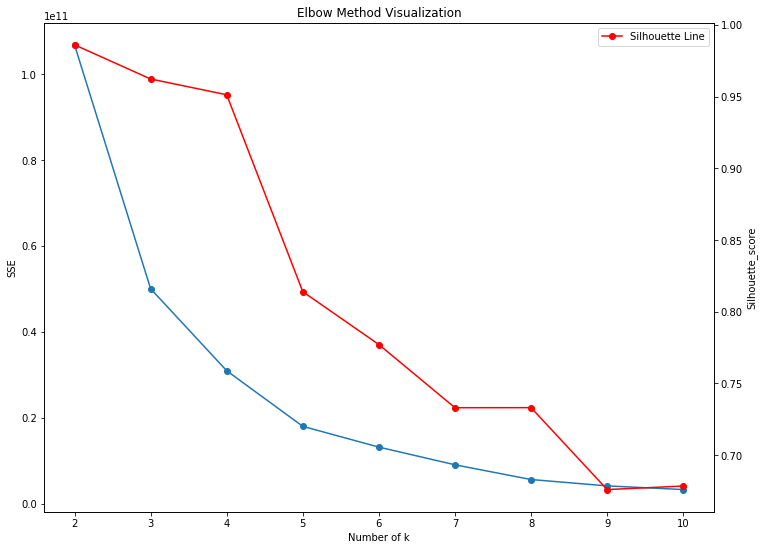

In [ ]:
sse, silhouette = kmeans_clustering(customer_rfm.drop('CustomerID', axis=1))

From this evaluation, we know that the number of suitable cluster is 5<br>
<br>
**Build Cluster Model and Snake Plot**

In [ ]:
def segmentation_model(df, customer_rfm, n_clusters):
    scale = StandardScaler()
    df_scale = scale.fit_transform(df)
    df_scale = pd.DataFrame(data = df_scale, columns=['recency','frequency','monetary'])

    #Final clustering on the data after we know the number of K
    model = KMeans(n_clusters=n_clusters, random_state=123)
    model.fit(df_scale)
    cluster_labels = model.labels_    
    
    #Assign cluster labels into customer_rfm
    customer_rfm = customer_rfm.assign(Cluster=cluster_labels)  
    df_scale = df_scale.assign(Cluster=cluster_labels)
    
    # inverse recency (the smaller the value, the better it is)
    # df_scale.recency = df_scale.recency*-1
    
    grouped_customer_rfm = customer_rfm.groupby(['Cluster']).agg({
                                 'recency': 'mean',
                                 'frequency': 'mean',
                                 'monetary': 'mean'
                                }).round(2) 
    print("\tCustomer Characteristic")
    display(grouped_customer_rfm)

    grouped_data = df_scale.groupby(['Cluster']).agg({
                              'recency': 'mean',
                              'frequency': 'mean',
                              'monetary': 'mean'
                            }).round(2) 
    print("\n\n\tCustomer Characteristic - Scaled Data")
    display(grouped_data)

    # grouped_data['avg'] = grouped_data[['recency','frequency','monetary']].mean(axis=1) 
    # grouped_data.sort_values(by='avg', ascending=False)
    # grouped_data['Label'] = [*np.arange(1, n_clusters+1)]
    # display(grouped_data.sort_values(by=['avg'], ascending=False))
    
    grouped_data = grouped_data.reset_index(level=['Cluster'])
    cols = ['recency','frequency','monetary']
    RFM_melt = pd.melt(grouped_data, id_vars='Cluster', value_vars=cols, var_name='Metric', value_name='Value')

    plt.figure(figsize=(12,5))
    plt.title('Snake plot')    # Add the x axis label
    plt.xlabel('Metric')    # Add the y axis label
    plt.ylabel('Value')    # Plot a line for each value of the cluster variable
    sns.lineplot(data=RFM_melt, x='Metric', y='Value', hue='Cluster', )
    plt.show() 
    
    return customer_rfm

	Customer Characteristic


,recency,frequency,monetary
Cluster,,,
0,11.38,18.37,11379.47
1,44.31,3.38,1306.56
2,248.88,1.50,518.17
3,9.00,37.40,195034.19
4,1.86,112.29,50302.14




	Customer Characteristic - Scaled Data


,recency,frequency,monetary
Cluster,,,
0,-0.81,2.16,1.12
1,-0.48,-0.09,-0.08
2,1.56,-0.37,-0.17
3,-0.84,5.02,22.90
4,-0.91,16.28,5.73


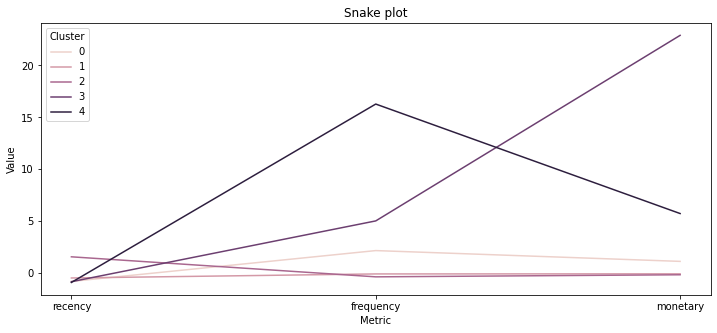

In [ ]:
customer_char = segmentation_model(customer_rfm.drop('CustomerID', axis=1), customer_rfm, 5)

In [ ]:
customer_char.Cluster.value_counts()

1    3021
2    1064
0     240
4       7
3       5
Name: Cluster, dtype: int64

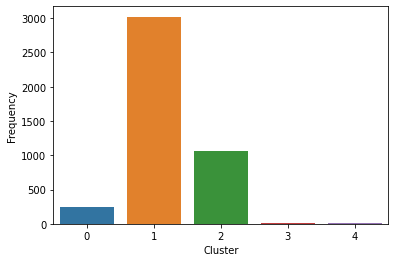

In [ ]:
sns.countplot(customer_char.Cluster)
plt.ylabel('Frequency')
plt.show()

In [ ]:
customer_char.sort_values(by='CustomerID').head()

,CustomerID,recency,frequency,monetary,Cluster
0,12347.0,2,7,4310.00,1
1,12348.0,75,4,1797.24,1
2,12349.0,19,1,1757.55,1
3,12350.0,310,1,334.40,2
4,12352.0,36,7,1545.41,1


#**Time Analysis**

In [ ]:
#take only the date from the InvoiceDate
df_time_data = customer_data.copy()
df_time_data.InvoiceDate = pd.to_datetime(df_time_data['InvoiceDate'].dt.strftime('%Y-%m-%d'))
df_time_data.head()

,Description,InvoiceDate,UnitPrice,CustomerID,Quantity,TotalPrice,BookID
0,4 purple flock dinner candles,2020-02-05,2.55,15012.0,2,5.10,2020-02-05 12:00:00
1,4 purple flock dinner candles,2020-02-09,2.55,18055.0,12,30.60,2020-02-09 10:00:00
2,4 purple flock dinner candles,2020-03-11,2.55,15464.0,1,2.55,2020-03-11 15:00:00
3,4 purple flock dinner candles,2020-04-01,2.55,17075.0,1,2.55,2020-04-01 13:00:00
4,4 purple flock dinner candles,2020-05-04,2.55,17841.0,1,2.55,2020-05-04 15:00:00


In [ ]:
ts_data = df_time_data.groupby(['InvoiceDate']).agg({'BookID':lambda x : x.count()}).reset_index(level=['InvoiceDate'])
ts_data.rename(columns={'BookID':'frequency'}, inplace=True)
ts_data.sort_values(by='InvoiceDate').head()

,InvoiceDate,frequency
0,2020-02-05,1821
1,2020-02-06,1814
2,2020-02-07,1071
3,2020-02-09,2510
4,2020-02-10,1848


**plot for all the date**

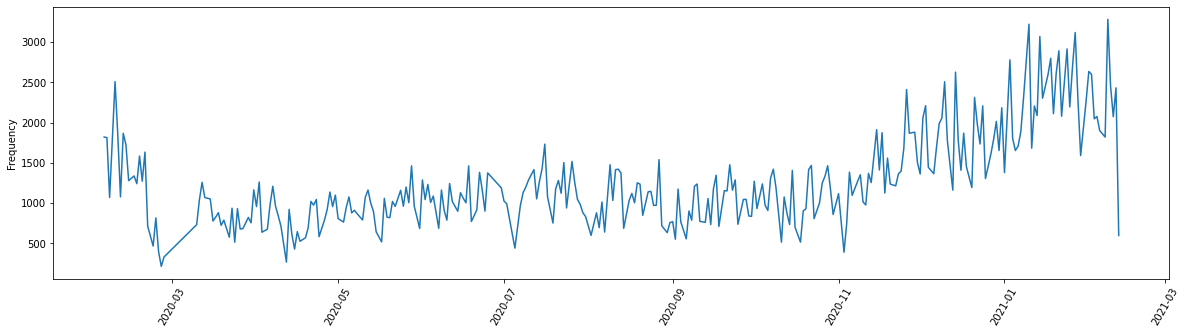

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ts_data['InvoiceDate'], ts_data['frequency'])
plt.xticks(rotation='60')
plt.ylabel('Frequency')
plt.show()

**Plot the data in April**

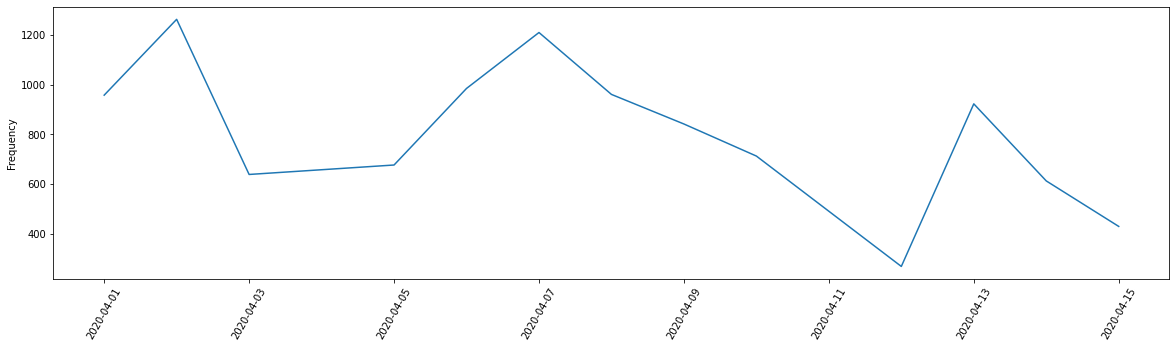

In [ ]:
data_april = ts_data[(ts_data.InvoiceDate >= '2020-04-01')&(ts_data.InvoiceDate <='2020-04-15')]
plt.figure(figsize=(20,5))
plt.plot(data_april['InvoiceDate'], data_april['frequency'])
plt.xticks(rotation='60')
plt.ylabel('Frequency')
plt.show()

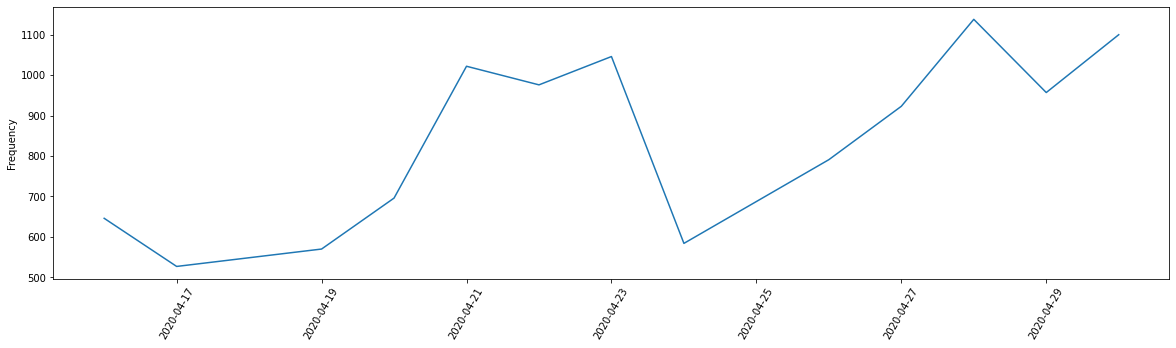

In [ ]:
data_april = ts_data[(ts_data.InvoiceDate >= '2020-04-16')&(ts_data.InvoiceDate <='2020-04-30')]
plt.figure(figsize=(20,5))
plt.plot(data_april['InvoiceDate'], data_april['frequency'])
plt.xticks(rotation='60')
plt.ylabel('Frequency')
plt.show()

**Plot the data in January 2021**

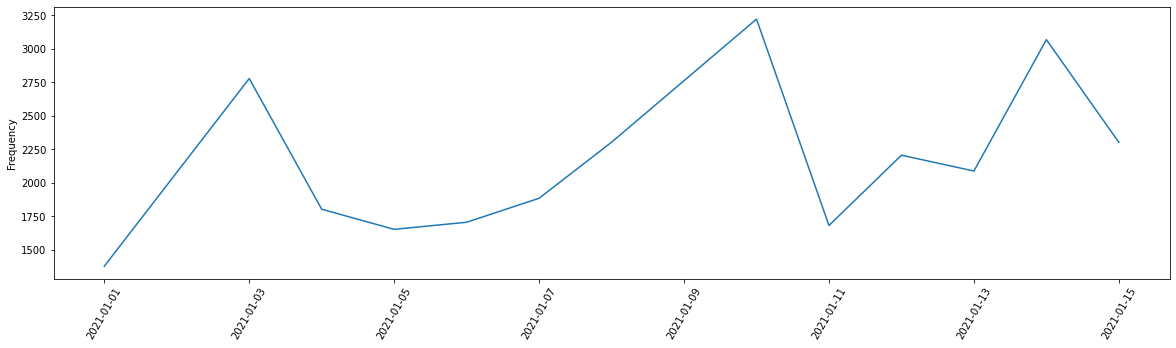

In [ ]:
data_januari = ts_data[(ts_data.InvoiceDate >= '2021-01-01')&(ts_data.InvoiceDate <='2021-01-15')]
plt.figure(figsize=(20,5))
plt.plot(data_januari['InvoiceDate'], data_januari['frequency'])
plt.xticks(rotation='60')
plt.ylabel('Frequency')
plt.show()

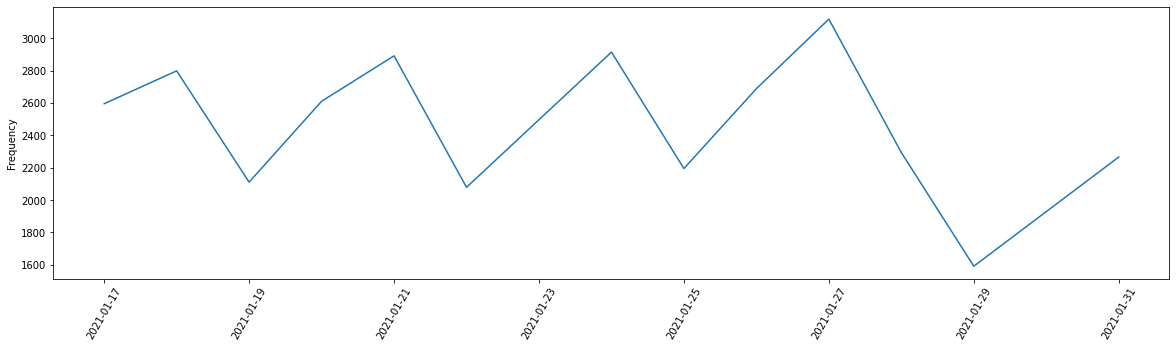

In [ ]:
data_januari = ts_data[(ts_data.InvoiceDate >= '2021-01-16')&(ts_data.InvoiceDate <='2021-01-31')]
plt.figure(figsize=(20,5))
plt.plot(data_januari['InvoiceDate'], data_januari['frequency'])
plt.xticks(rotation='60')
plt.ylabel('Frequency')
plt.show()

#**Product Analysis**

In [ ]:
product = df3.copy()
product = product.fillna(00000)

In [ ]:
# handling missng customer (because we just need the product number)
product.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

In [ ]:
product.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,white hanging heart t-light holder,6,2020-02-05 08:26:00,2.55,17850.0
1,536365,71053,white metal lantern,6,2020-02-05 08:26:00,3.39,17850.0
2,536365,84406B,cream cupid hearts coat hanger,8,2020-02-05 08:26:00,2.75,17850.0
3,536365,84029G,knitted union flag hot water bottle,6,2020-02-05 08:26:00,3.39,17850.0
4,536365,84029E,red woolly hottie white heart.,6,2020-02-05 08:26:00,3.39,17850.0


In [ ]:
#handling cancel ordering
product_group = product.groupby(['Description','UnitPrice','CustomerID']).agg({'Quantity':'sum'})
product_group = product_group.reset_index(level=['Description','UnitPrice','CustomerID'])
product_group.head()

,Description,UnitPrice,CustomerID,Quantity
0,4 purple flock dinner candles,0.79,13949.0,12
1,4 purple flock dinner candles,0.79,14071.0,1
2,4 purple flock dinner candles,0.79,15621.0,12
3,4 purple flock dinner candles,0.79,16779.0,12
4,4 purple flock dinner candles,0.79,17315.0,12


In [ ]:
#take only the product transaction
product_group = product_group[(product_group.Quantity>0)]
product_group.describe()

,UnitPrice,CustomerID,Quantity
count,284513.000000,284513.000000,284513.000000
mean,3.785237,14735.325676,18.867872
std,26.372114,3291.815787,89.702828
min,0.000000,0.000000,1.000000
25%,1.250000,13668.000000,2.000000
50%,1.950000,15088.000000,6.000000
75%,3.750000,16729.000000,12.000000
max,4505.170000,18287.000000,12540.000000


In [ ]:
product_group.head()

,Description,UnitPrice,CustomerID,Quantity
0,4 purple flock dinner candles,0.79,13949.0,12
1,4 purple flock dinner candles,0.79,14071.0,1
2,4 purple flock dinner candles,0.79,15621.0,12
3,4 purple flock dinner candles,0.79,16779.0,12
4,4 purple flock dinner candles,0.79,17315.0,12


In [ ]:
#best selling product
product_final = product_group.groupby(['Description']).agg({'Quantity':'sum'})
product_final = product_final.reset_index(level=['Description'])
product_final = product_final.sort_values(by='Quantity', ascending=False)
product_final.head(10)

,Description,Quantity
3965,world war 2 gliders asstd designs,53943
1837,jumbo bag red retrospot,47475
2705,popcorn holder,36459
234,assorted colour bird ornament,36389
2364,pack of 72 retrospot cake cases,36132
3875,white hanging heart t-light holder,35320
2765,rabbit night light,30691
2134,mini paint set vintage,26437
2330,pack of 12 london tissues,26315
2362,pack of 60 pink paisley cake cases,24757


In [ ]:
#the product didn't sell very well
product_final.sort_values(by='Quantity').head(10)

,Description,Quantity
1209,etched glass star tree decoration,1
388,black glass/shell/pearl necklace,1
2069,marie antoienett trinket box gold,1
3109,set 36 colouring pencils doiley,1
3169,set of 3 pink flying ducks,1
479,blue new baroque flock candlestick,1
1350,for online retail orders,1
1109,dusty pink christmas tree 30cm,1
3306,set/6 ivory bird t-light candles,1
2543,pink crystal guitar phone charm,1


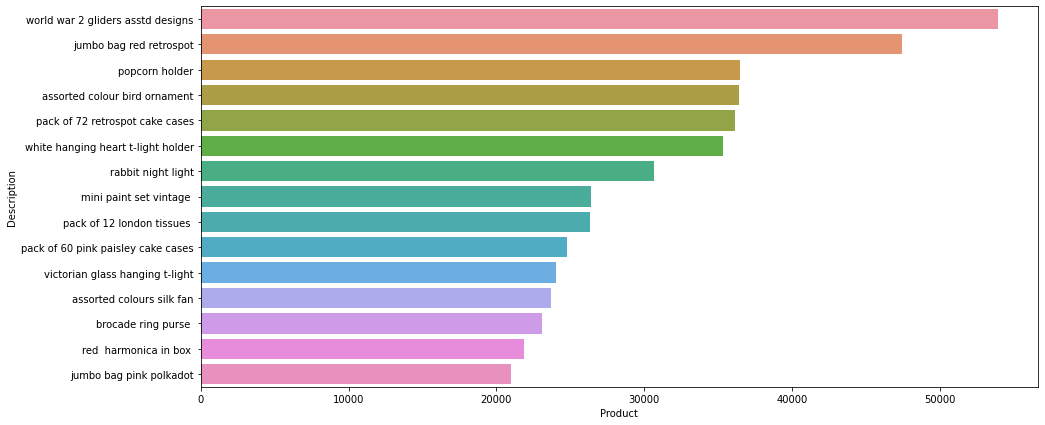

In [ ]:
plt.figure(figsize=(15, 7))
best_seller = product_final.sort_values(by='Quantity', ascending=False).head(15)
sns.barplot(x=best_seller.Quantity, y=best_seller.Description)
plt.xlabel('Product')
plt.show()